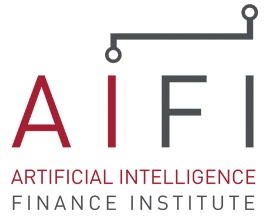


# Bootcamp - Python and Coding - Deep Learning

# Dense Neural Networks (DNN)

# About this notebook

This is an introduction to dense neural networks. The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer. The dense layer is found to be the most commonly used layer in the models.

In the background, the dense layer performs a matrix-vector multiplication. The values used in the matrix are actually parameters that can be trained and updated with the help of backpropagation.

The output generated by the dense layer is an $m$ dimensional vector. Thus, dense layer is basically used for changing the dimensions of the vector. Dense layers also applies operations like rotation, scaling, translation on the vector.

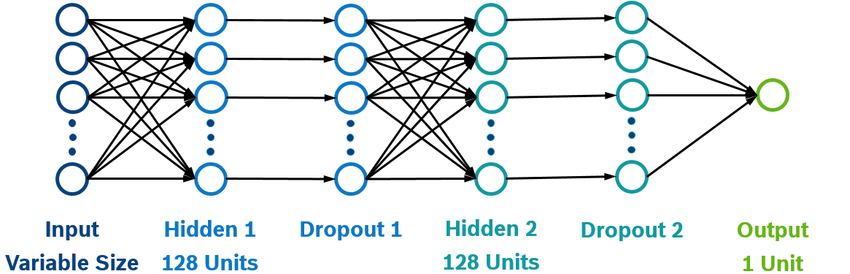

Sample dense neural network with 2 fully connected layers, 2 dropout layers and a decision layer with sigmoid activation.

# Imports

In [1]:
# standard imports
import os
import numpy as np
import pandas as pd
import random
import time

# deep learning imports
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1, l2

# sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from scikeras.wrappers import KerasClassifier

# import for scraping
import yfinance as yf

# plotting
from pylab import plt, mpl

In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('../../custom_plot_style.mplstyle')  

## Data

In [3]:

raw = yf.download("EURUSD=X", start="2002-08-01", end="2022-08-01")

[*********************100%***********************]  1 of 1 completed


In [4]:
raw.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0


In [5]:
raw.shape

(4842, 6)

In [6]:
symbol = 'CHF_USD'

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4842 entries, 2003-12-01 to 2022-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4842 non-null   float64
 1   High       4842 non-null   float64
 2   Low        4842 non-null   float64
 3   Close      4842 non-null   float64
 4   Adj Close  4842 non-null   float64
 5   Volume     4842 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 264.8 KB


In [8]:
# construct data for model
data = pd.DataFrame(raw['Adj Close'].loc[:])
data.rename(columns={'Adj Close': 'close'})
data.columns = [symbol]

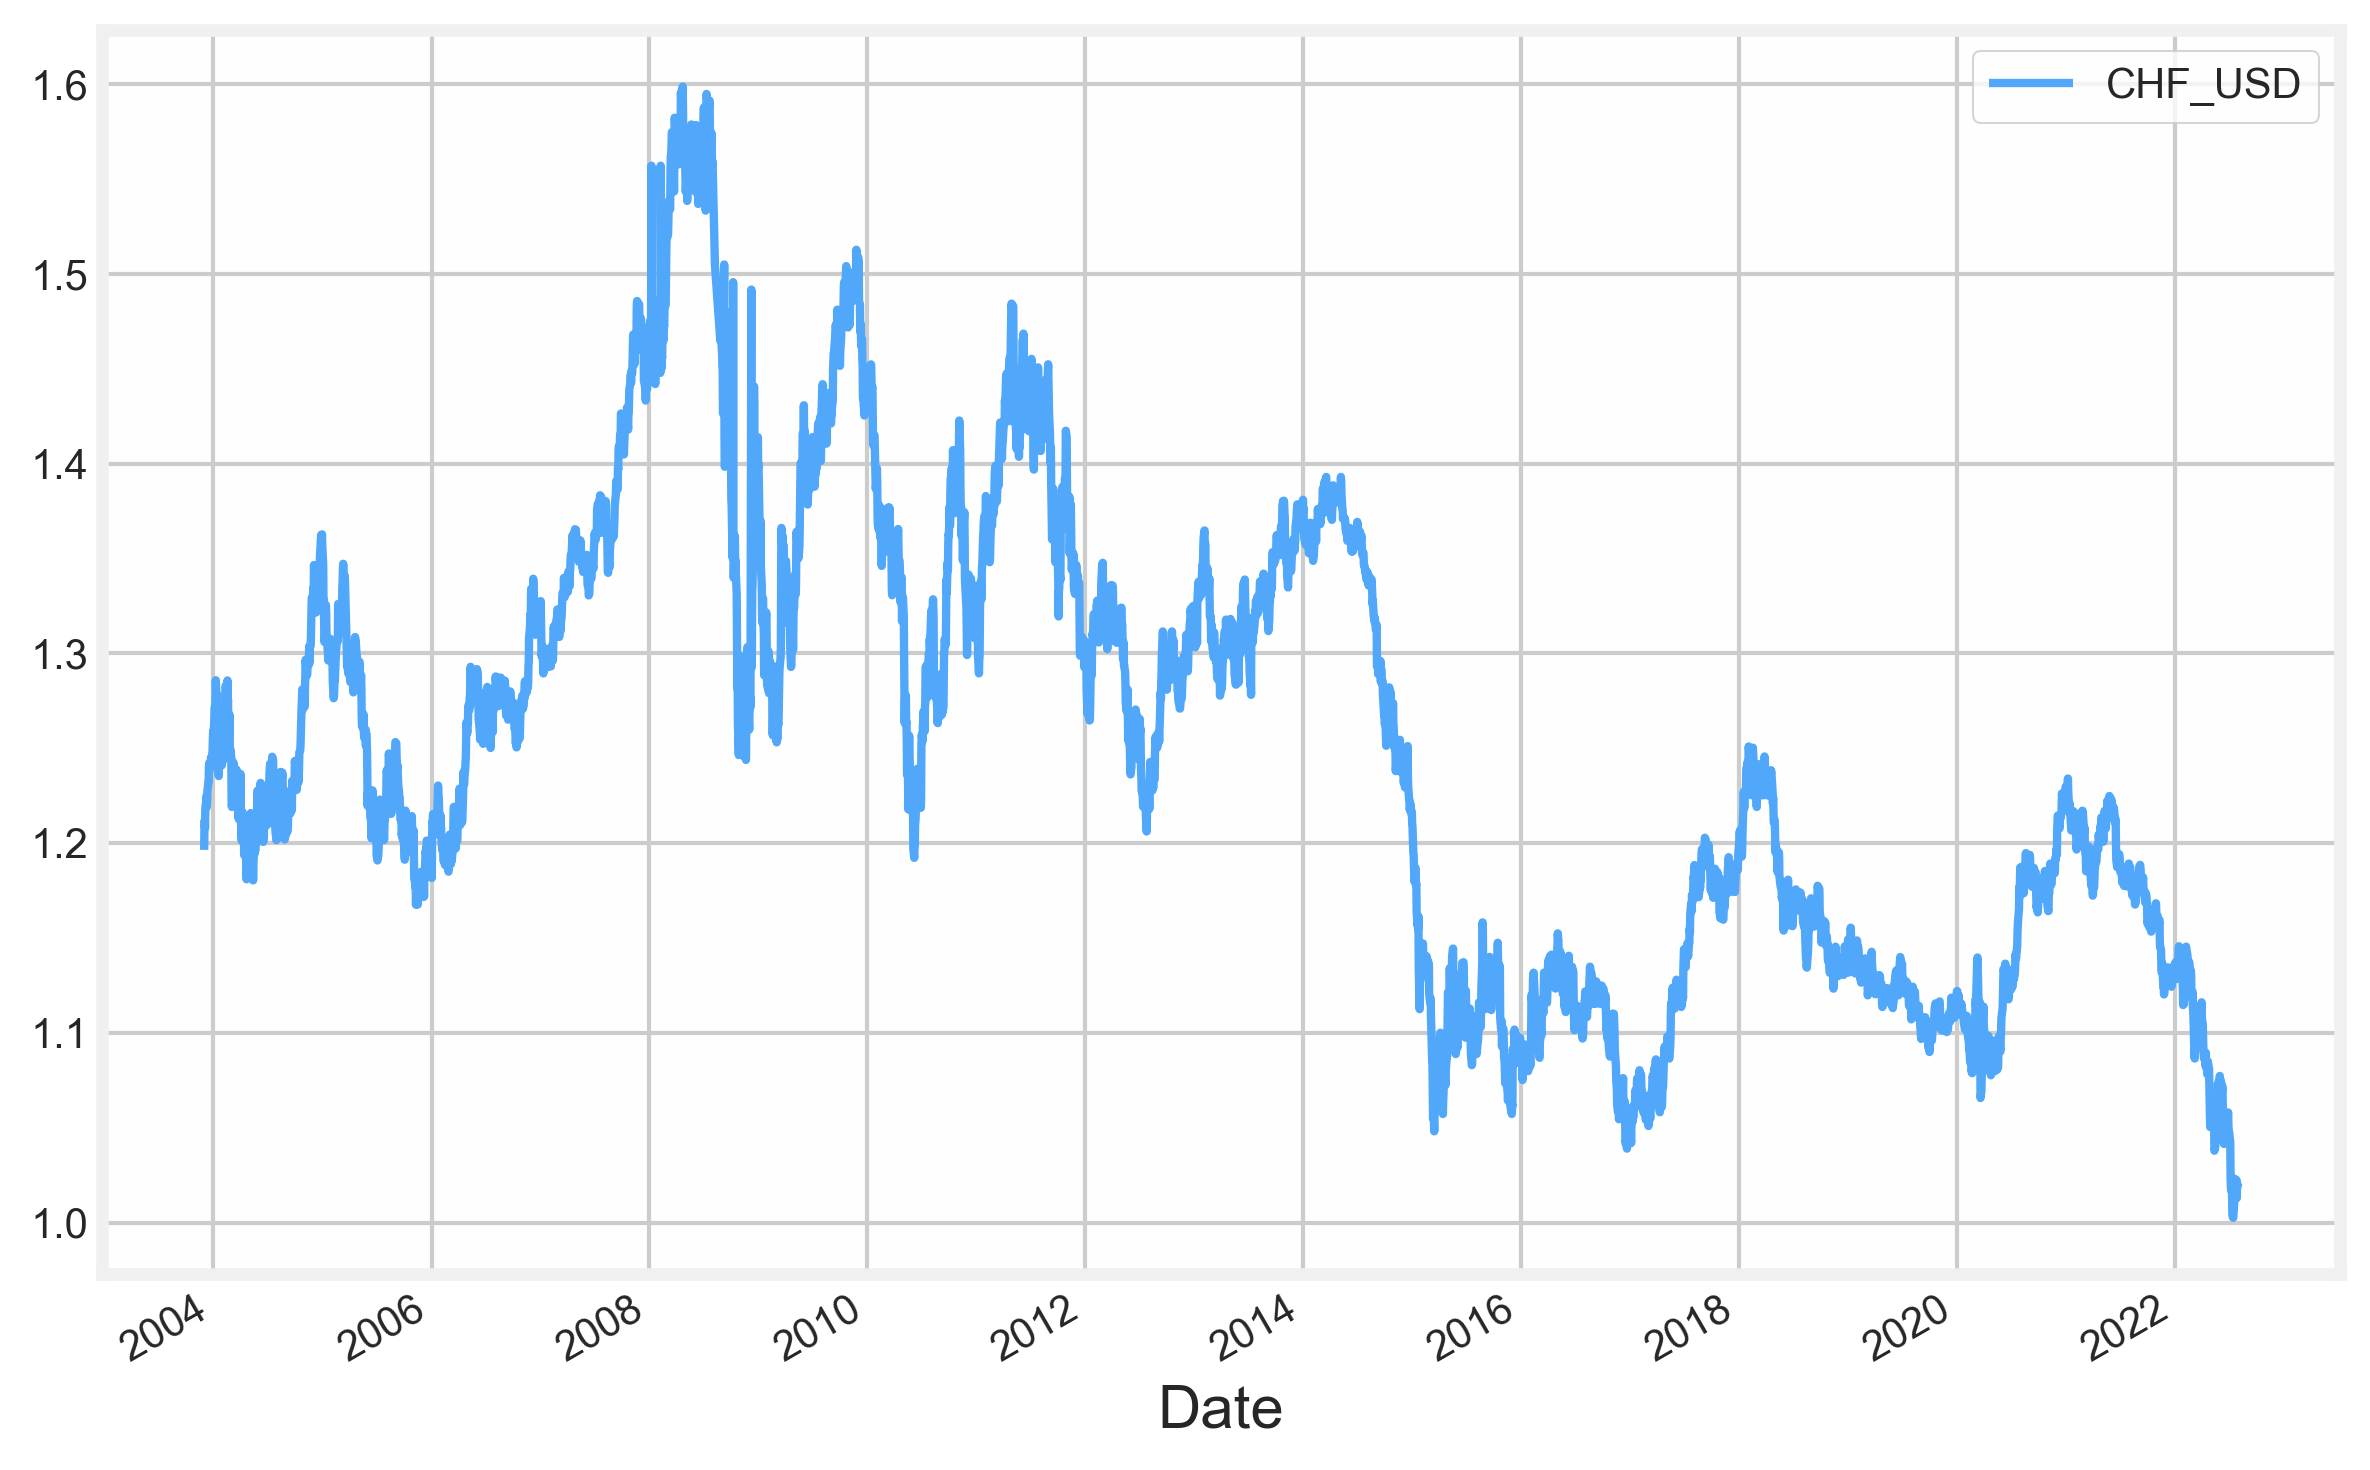

In [9]:
data.plot();

## Baseline Prediction

In [10]:
lags = 5

In [11]:
def add_lags(data, symbol, lags, window=21):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [12]:
data, cols = add_lags(data, symbol, lags)

In [13]:
len(data)

4816

In [14]:
c = data['d'].value_counts()
c

0    2421
1    2395
Name: d, dtype: int64

In [15]:
data['d']

Date
2004-01-06    1
2004-01-07    0
2004-01-08    1
2004-01-09    1
2004-01-12    0
             ..
2022-07-26    1
2022-07-27    0
2022-07-28    1
2022-07-29    0
2022-08-01    1
Name: d, Length: 4816, dtype: int64

In [16]:
def get_class_weight(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [17]:
class_weight = get_class_weight(data)

In [18]:
class_weight[0] * c[0]

2408.0

In [19]:
class_weight[1] * c[1]

2408.0

In [20]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [21]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [22]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.7)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [23]:
activation = 'relu'
def create_model(hl=1, hu=128, activation=activation, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation=activation))
    for _ in range(hl):
        model.add(Dense(hu, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [89]:
set_seeds()
model = create_model(hl=1, hu=128)

In [25]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=get_class_weight(data))

CPU times: user 10.8 s, sys: 6.44 s, total: 17.3 s
Wall time: 6.93 s


In [26]:
model.evaluate(data[cols], data['d'])

151/151 [==============================] - 0s 591us/step - loss: 0.6886 - accuracy: 0.5357


[0.6886281371116638, 0.5357142686843872]

In [27]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

In [28]:
data['p'].value_counts()

1    2743
0    2073
Name: p, dtype: int64

In [29]:
split = int(len(data) * 0.8)

In [30]:
train = data.iloc[:split].copy()

In [31]:
test = data.iloc[split:].copy()

In [32]:
set_seeds()
model = create_model(hl=1, hu=128)

In [33]:
%%time 
hist = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=get_class_weight(train))

CPU times: user 8.22 s, sys: 4.1 s, total: 12.3 s
Wall time: 5.68 s


In [34]:
model.evaluate(train[cols], train['d'])

121/121 [==============================] - 0s 597us/step - loss: 0.6901 - accuracy: 0.5382


[0.6900784373283386, 0.5381619930267334]

In [35]:
model.evaluate(test[cols], test['d'])

31/31 [==============================] - 0s 609us/step - loss: 0.6943 - accuracy: 0.4938


[0.6942856907844543, 0.4937759339809418]

In [36]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

In [37]:
test['p'].value_counts()

0    531
1    433
Name: p, dtype: int64

In [38]:
res = pd.DataFrame(hist.history)

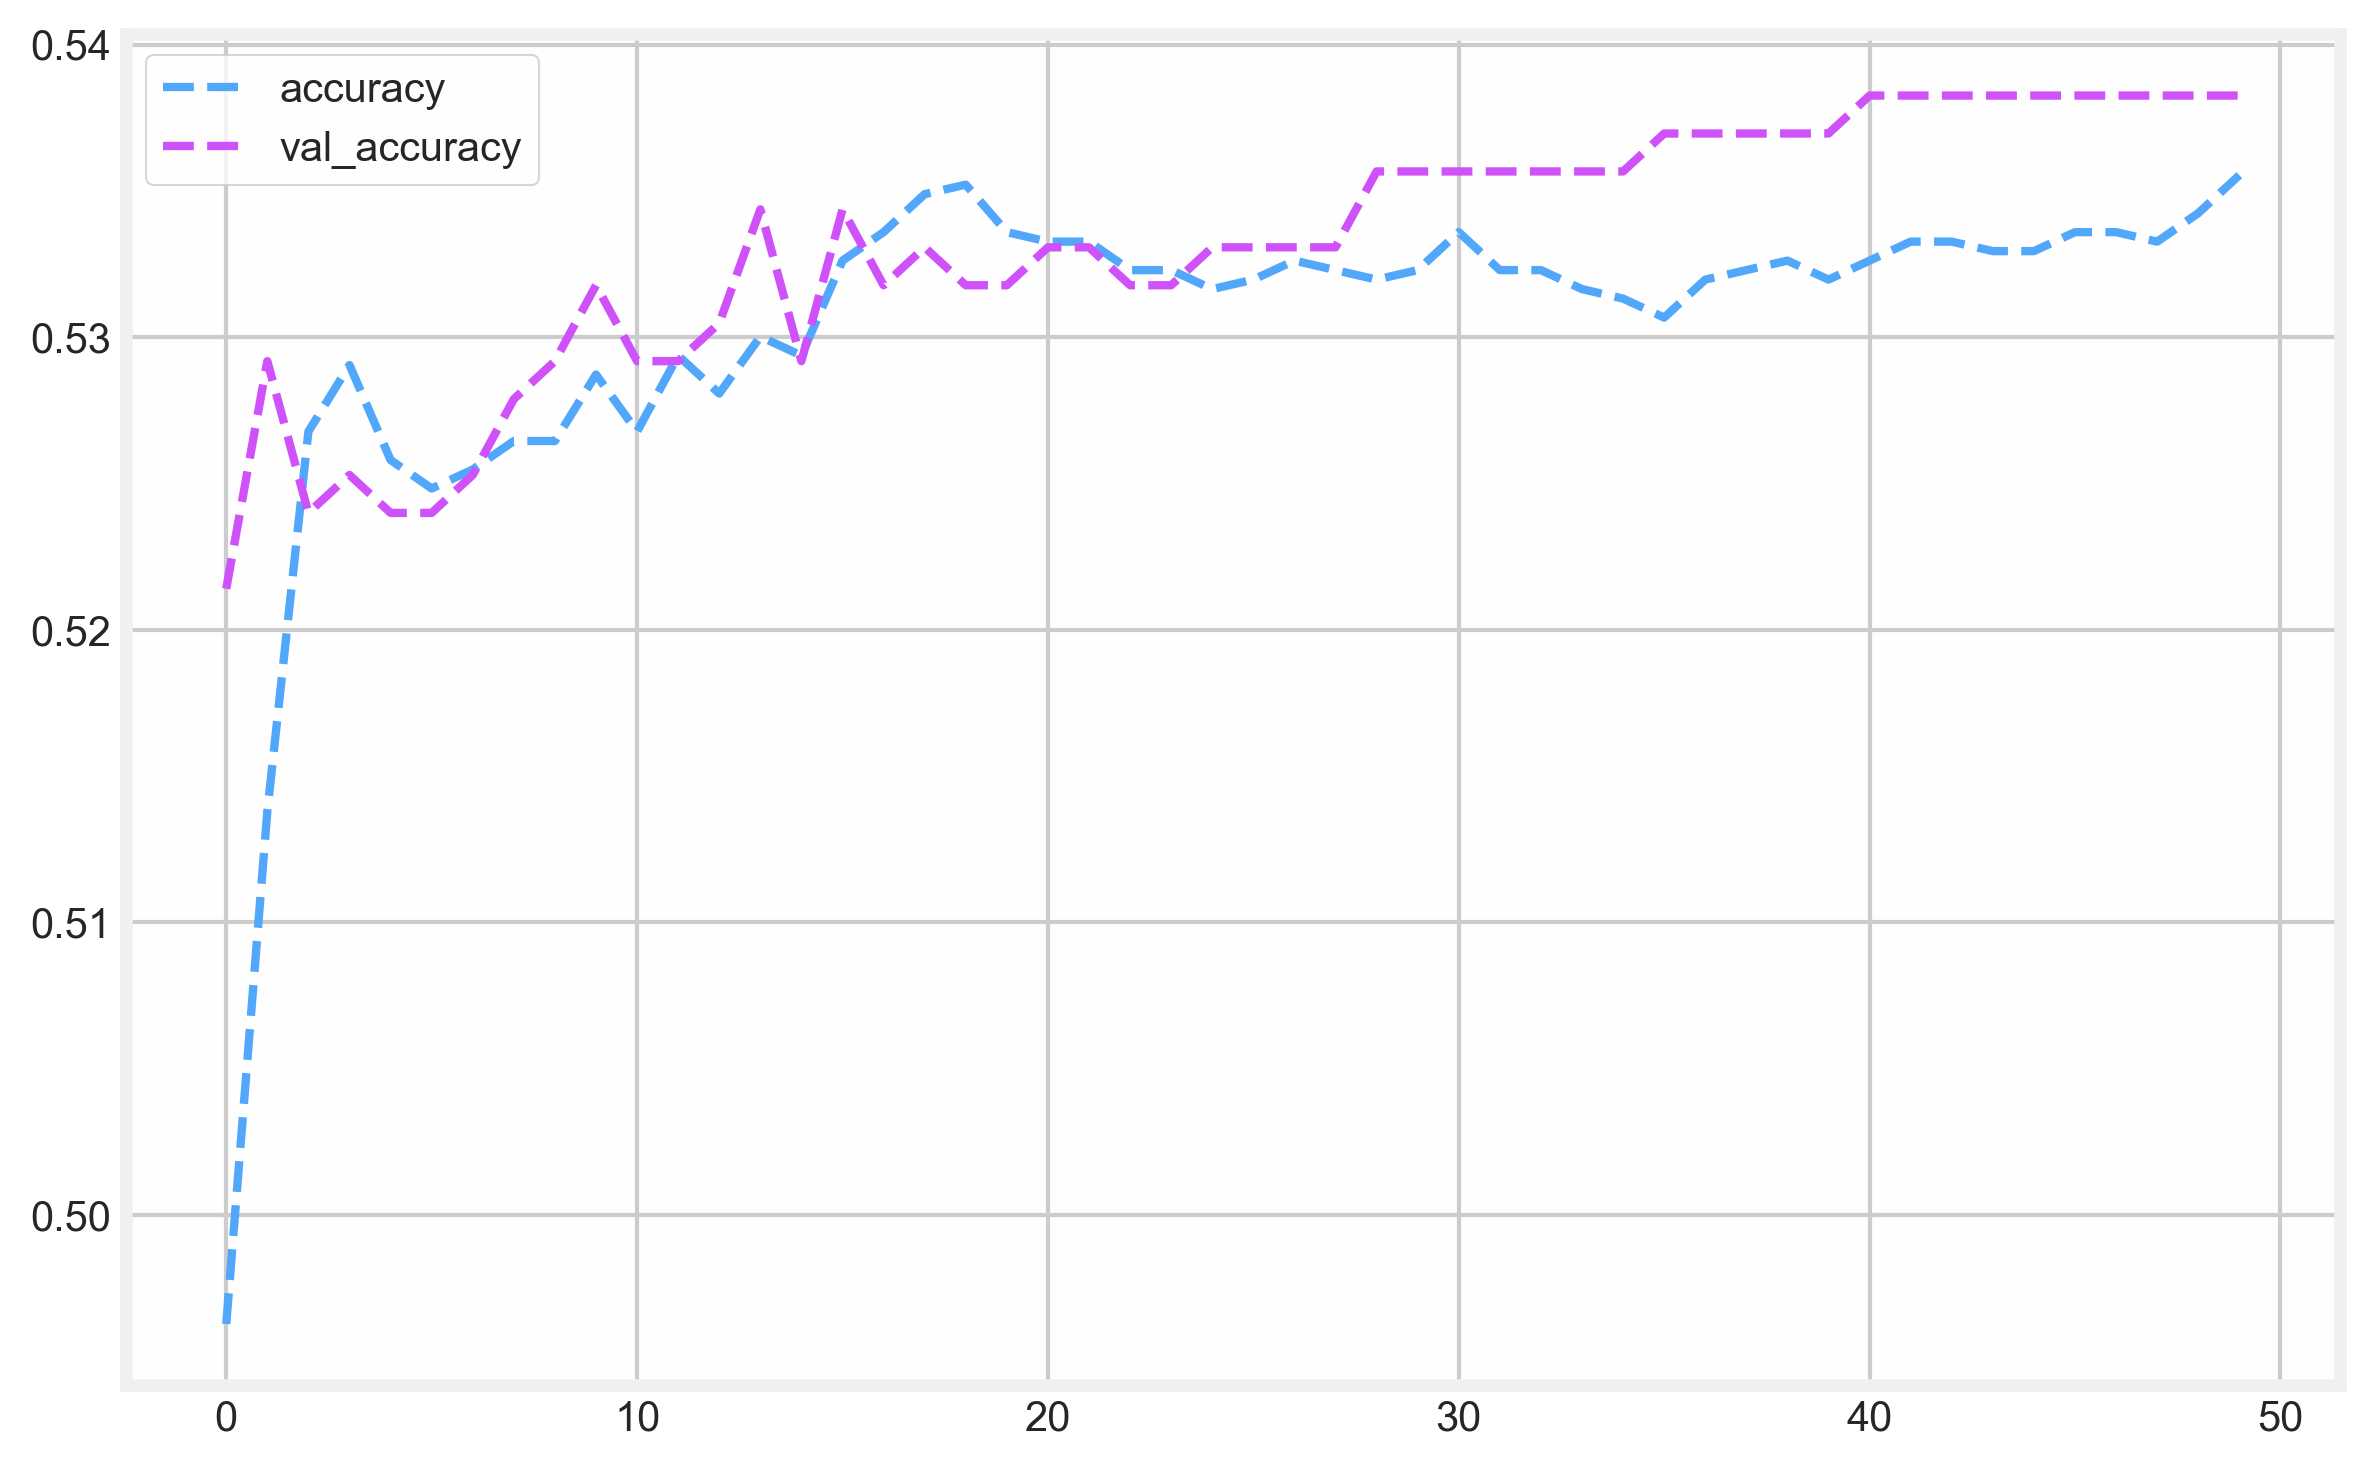

In [39]:
res[['accuracy', 'val_accuracy']].plot(style='--');

## Normalization

In [40]:
mu, std = train.mean(), train.std()

In [41]:
train_ = (train - mu) / std

In [42]:
set_seeds()
model = create_model(hl=2, hu=128)

In [43]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=get_class_weight(train))

CPU times: user 10.2 s, sys: 6.47 s, total: 16.7 s
Wall time: 6.39 s


In [44]:
model.evaluate(train_[cols], train['d'])

121/121 [==============================] - 0s 749us/step - loss: 0.6842 - accuracy: 0.5540


[0.6841862797737122, 0.5539979338645935]

In [45]:
test_ = (test - mu) / std

In [46]:
model.evaluate(test_[cols], test['d'])

31/31 [==============================] - 0s 798us/step - loss: 0.6942 - accuracy: 0.5031


[0.6941807270050049, 0.5031120181083679]

In [47]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [48]:
test['p'].value_counts()

0    544
1    420
Name: p, dtype: int64

In [49]:
res = pd.DataFrame(hist.history)

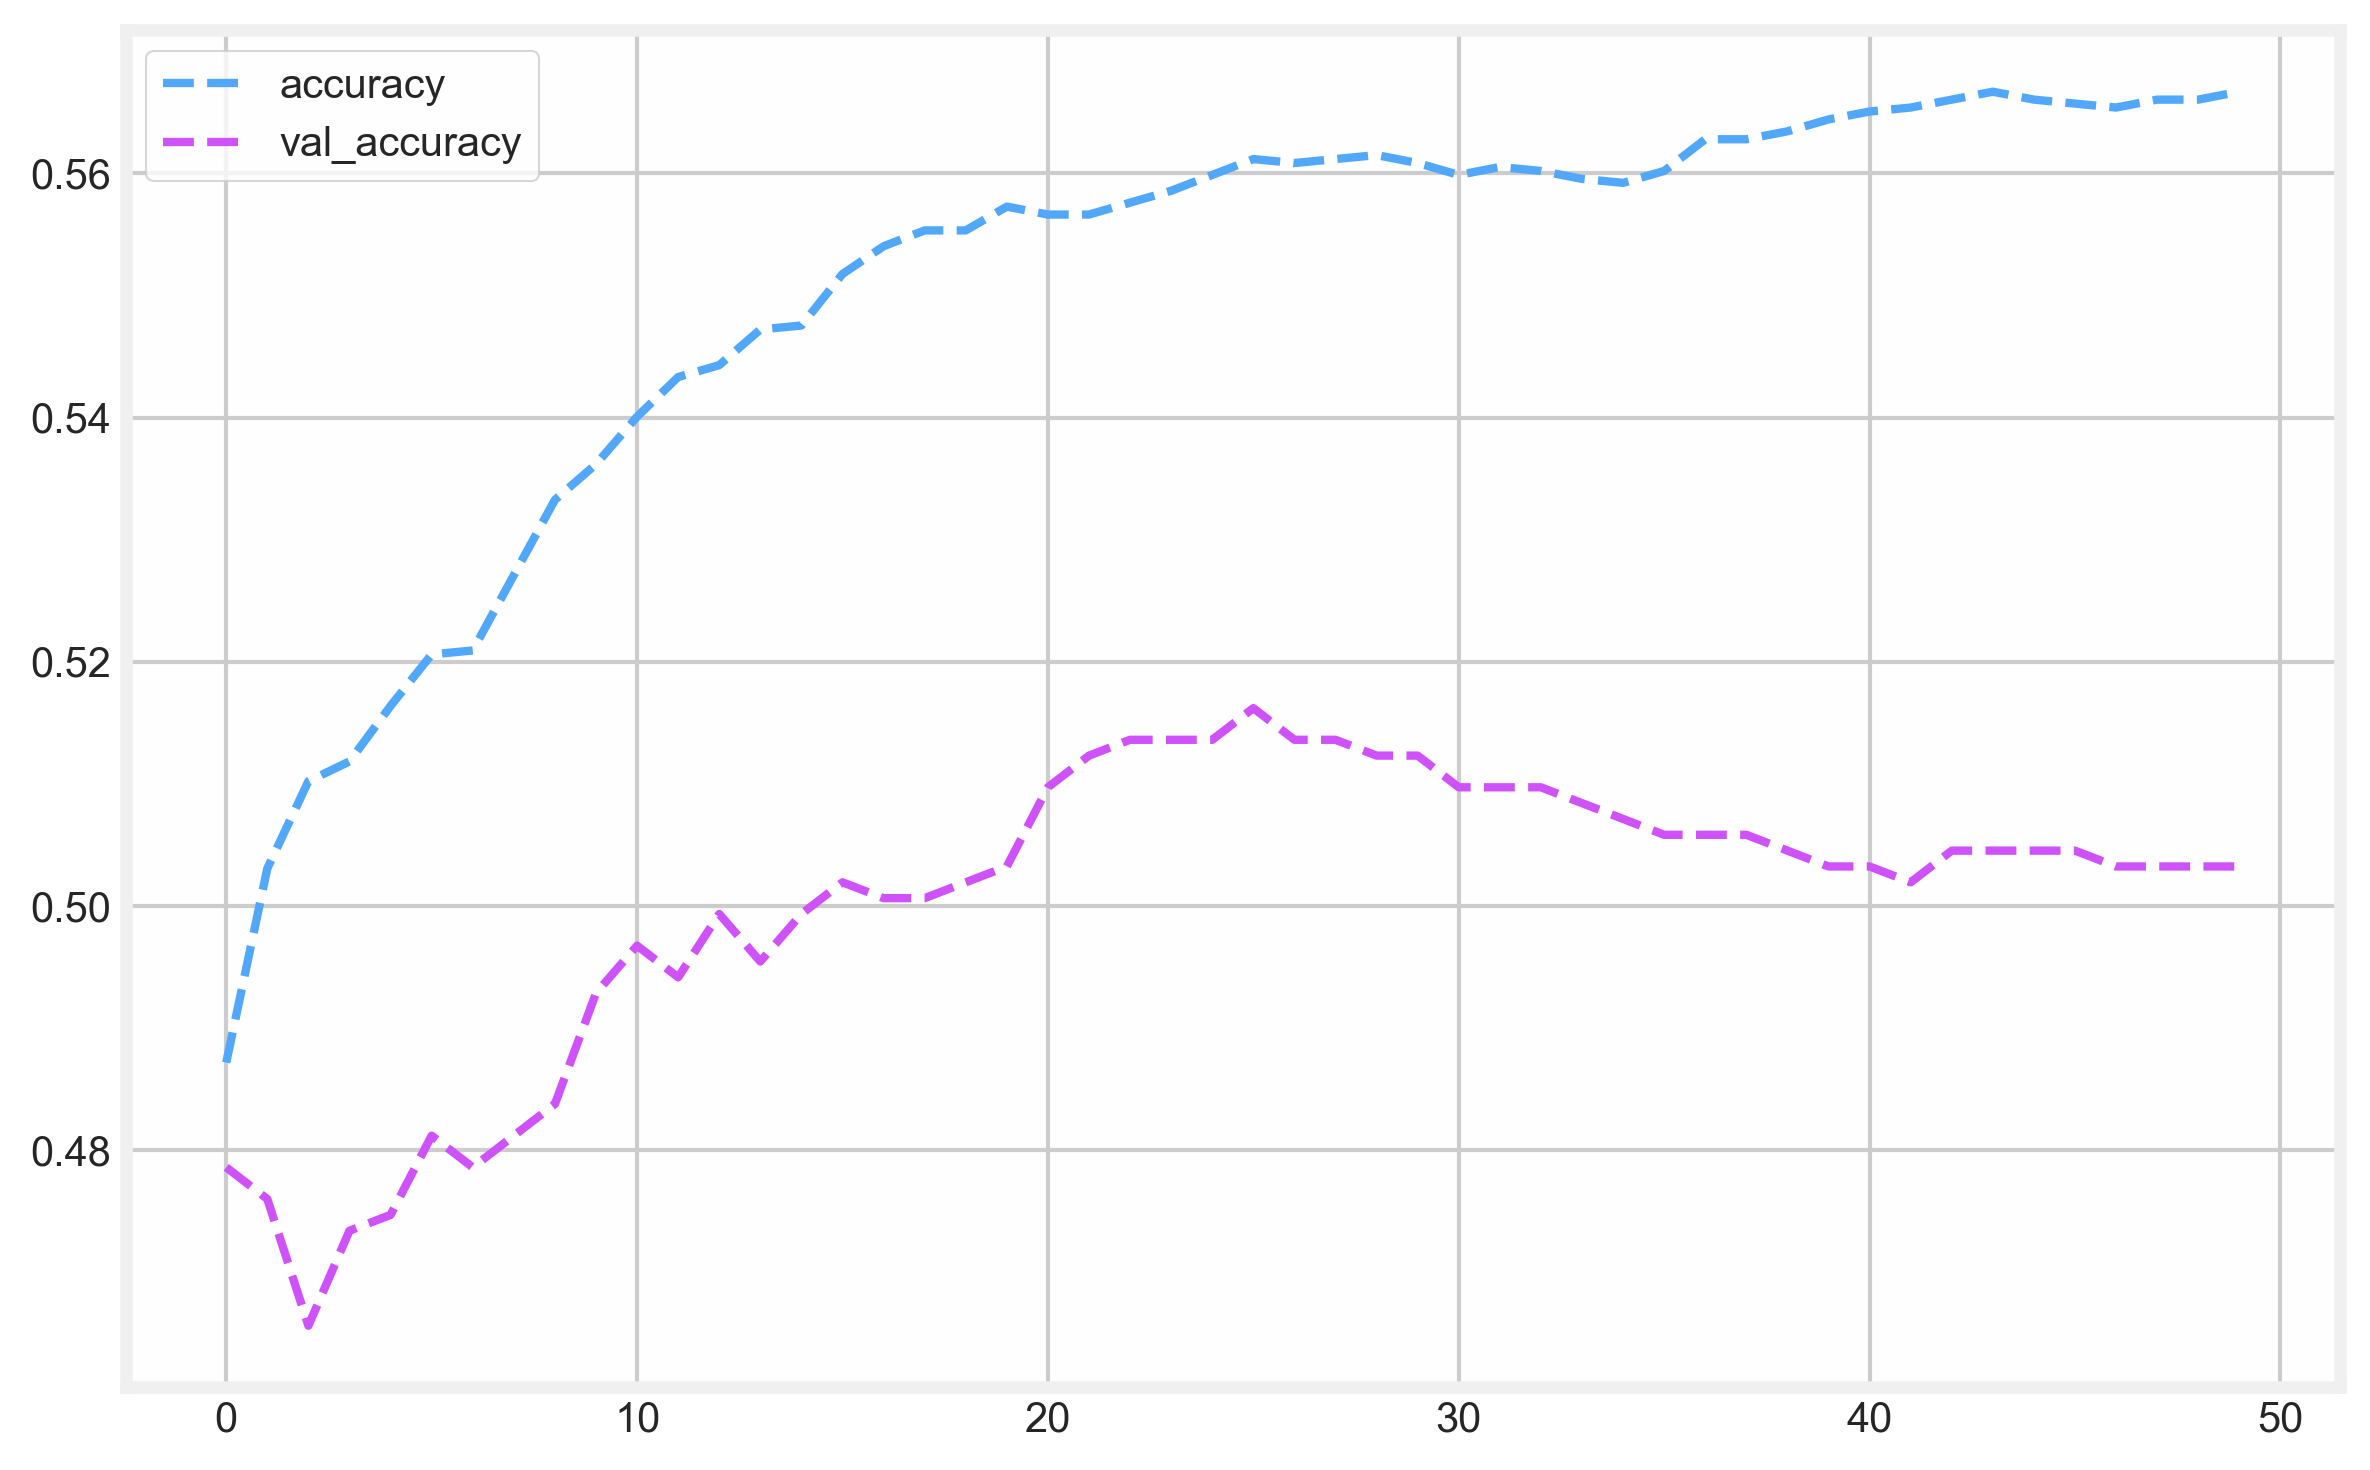

In [50]:
res[['accuracy', 'val_accuracy']].plot(style='--');

---

## Dropout 

Dropout is a technique meant to prevent overfitting the training data by dropping out units in a neural network. In practice, neurons are either dropped with probability $p$ or kept with probability $1-p$.

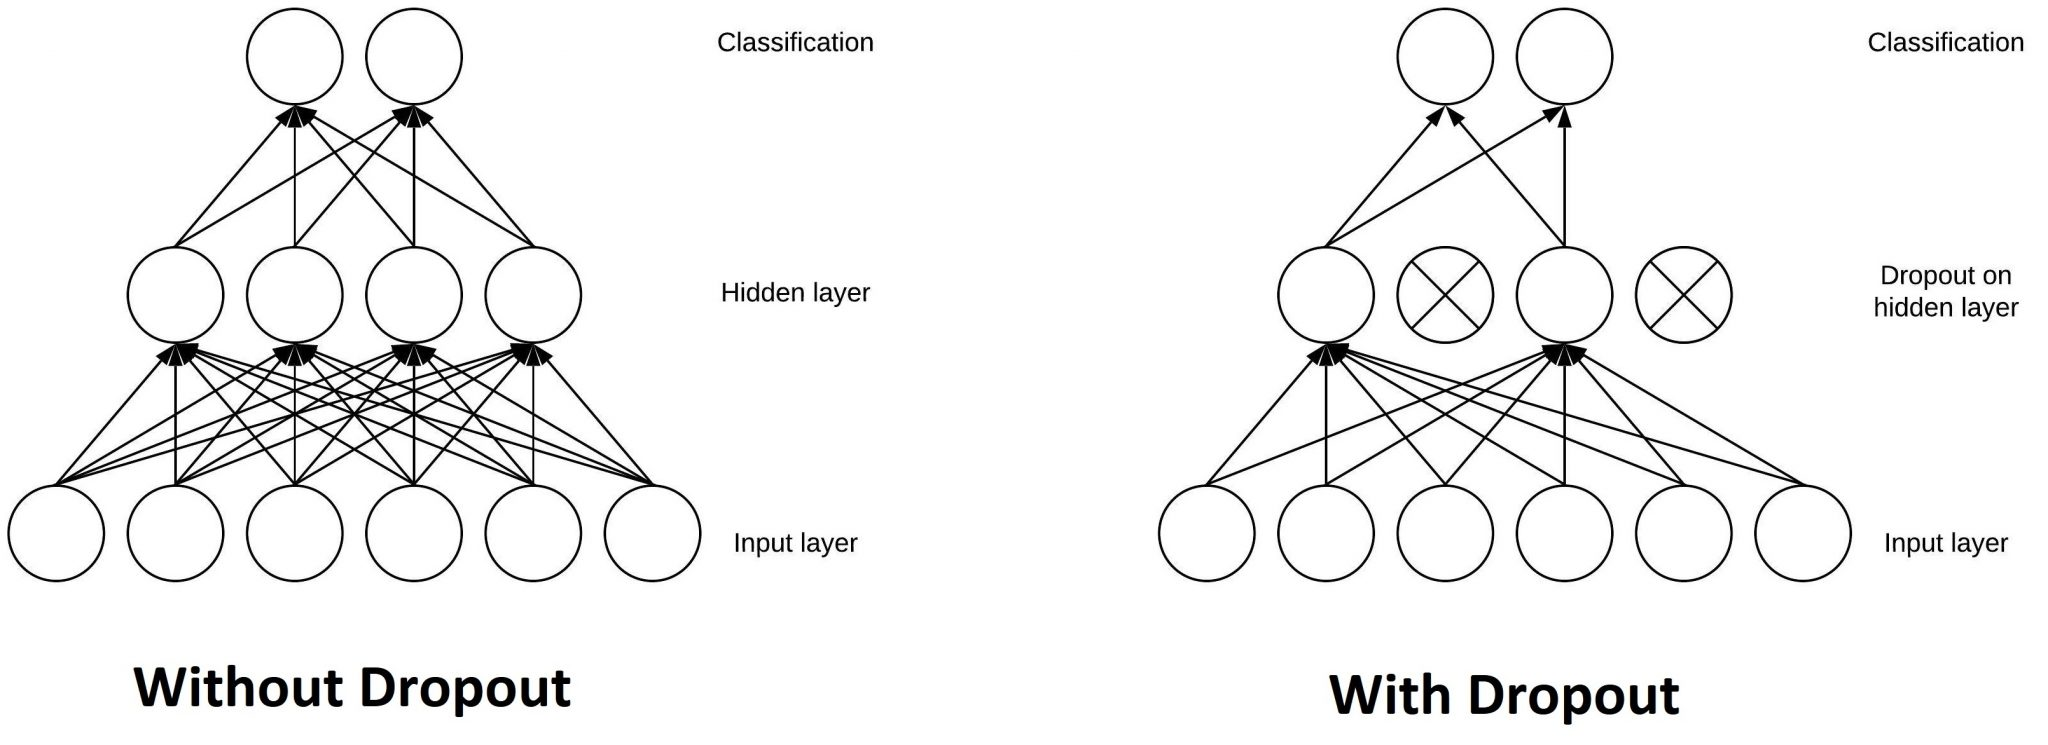

In [51]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                 optimizer=optimizer, activation=activation):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation=activation))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation=activation))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [52]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [53]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=get_class_weight(train))

CPU times: user 8.99 s, sys: 4.51 s, total: 13.5 s
Wall time: 6.28 s


In [54]:
model.evaluate(train_[cols], train['d'])

121/121 [==============================] - 0s 685us/step - loss: 0.6958 - accuracy: 0.4964


[0.695753812789917, 0.4963655173778534]

In [55]:
model.evaluate(test_[cols], test['d'])

31/31 [==============================] - 0s 790us/step - loss: 0.6964 - accuracy: 0.4834


[0.6963908076286316, 0.4834024906158447]

In [56]:
res = pd.DataFrame(hist.history)

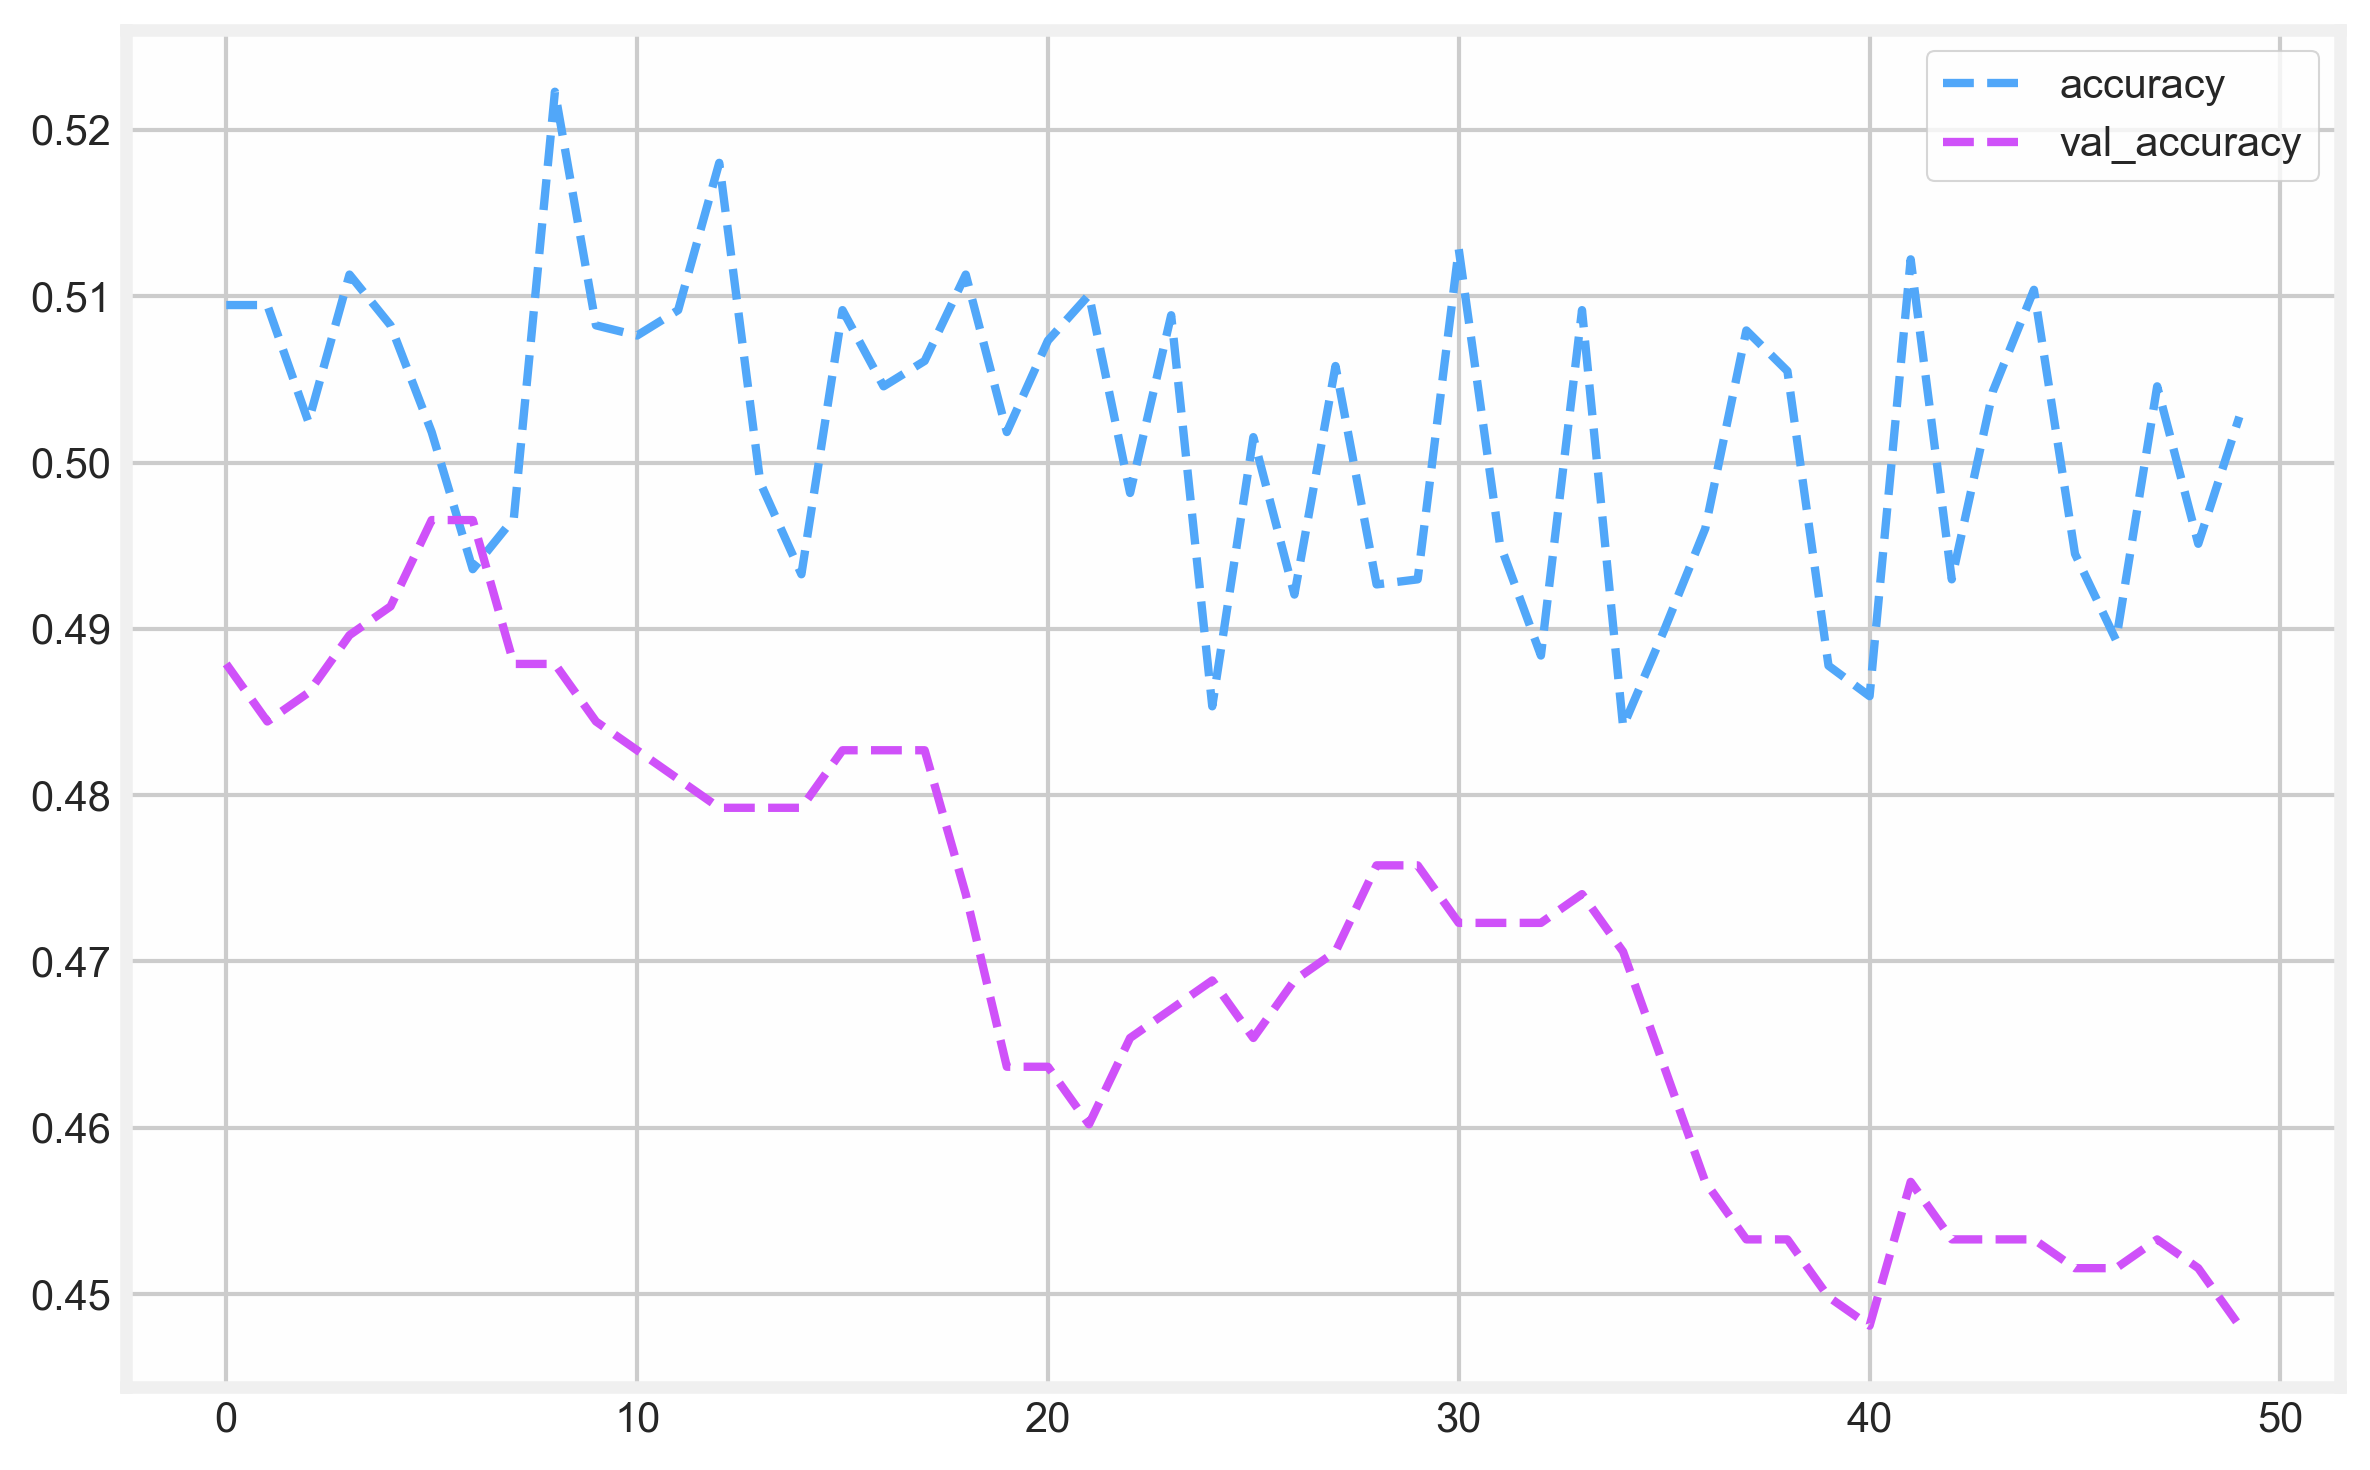

In [57]:
res[['accuracy', 'val_accuracy']].plot(style='--');

## Regularization 

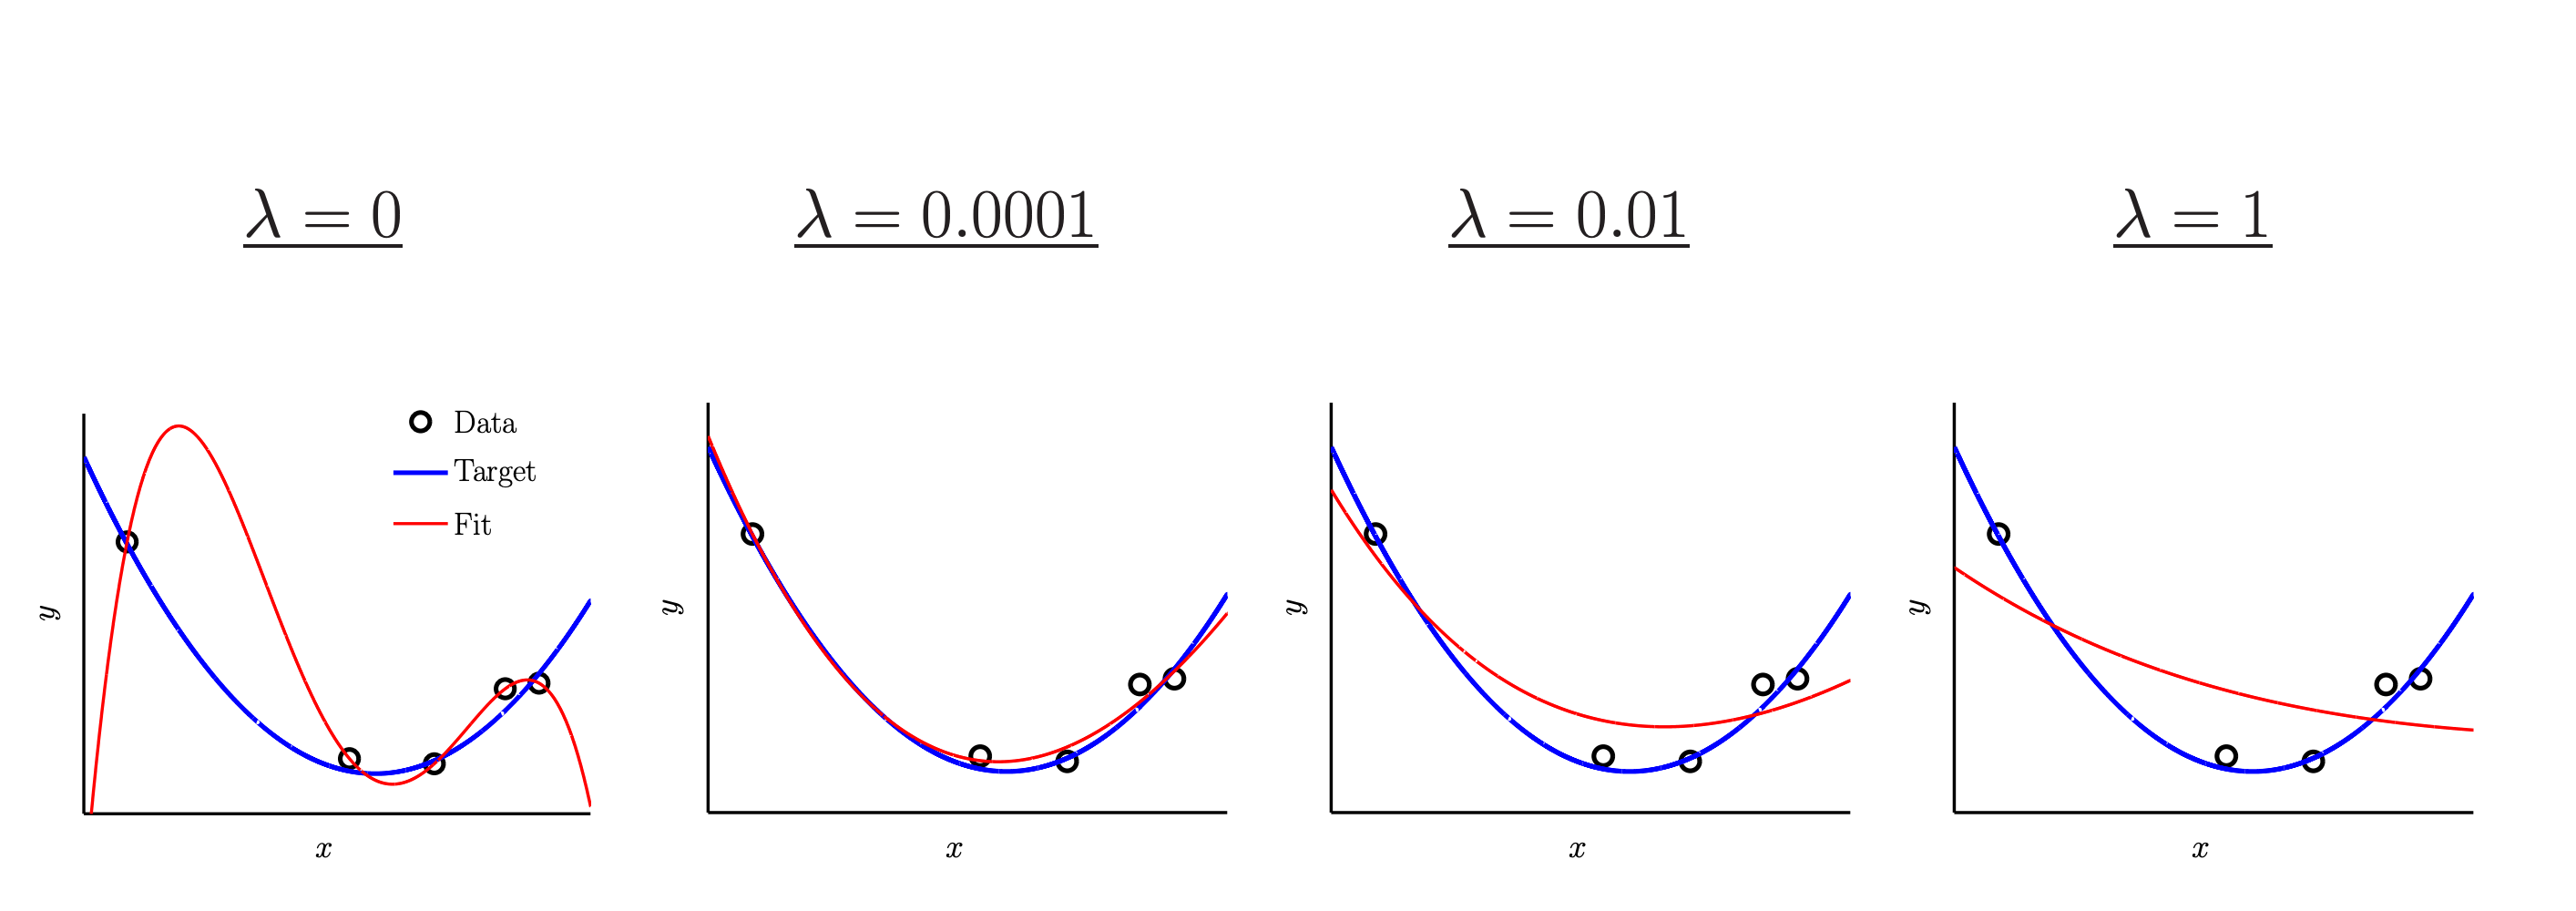

In [58]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, 
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, activation=activation, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation=activation))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation=activation,
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [59]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [60]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=get_class_weight(train))

CPU times: user 9.19 s, sys: 4.33 s, total: 13.5 s
Wall time: 5.93 s


In [61]:
model.evaluate(train_[cols], train['d'])

121/121 [==============================] - 0s 634us/step - loss: 0.7427 - accuracy: 0.5018


[0.7427123785018921, 0.5018172264099121]

In [62]:
model.evaluate(test_[cols], test['d'])

31/31 [==============================] - 0s 748us/step - loss: 0.7387 - accuracy: 0.4938


[0.7387259006500244, 0.4937759339809418]

In [63]:
res = pd.DataFrame(hist.history)

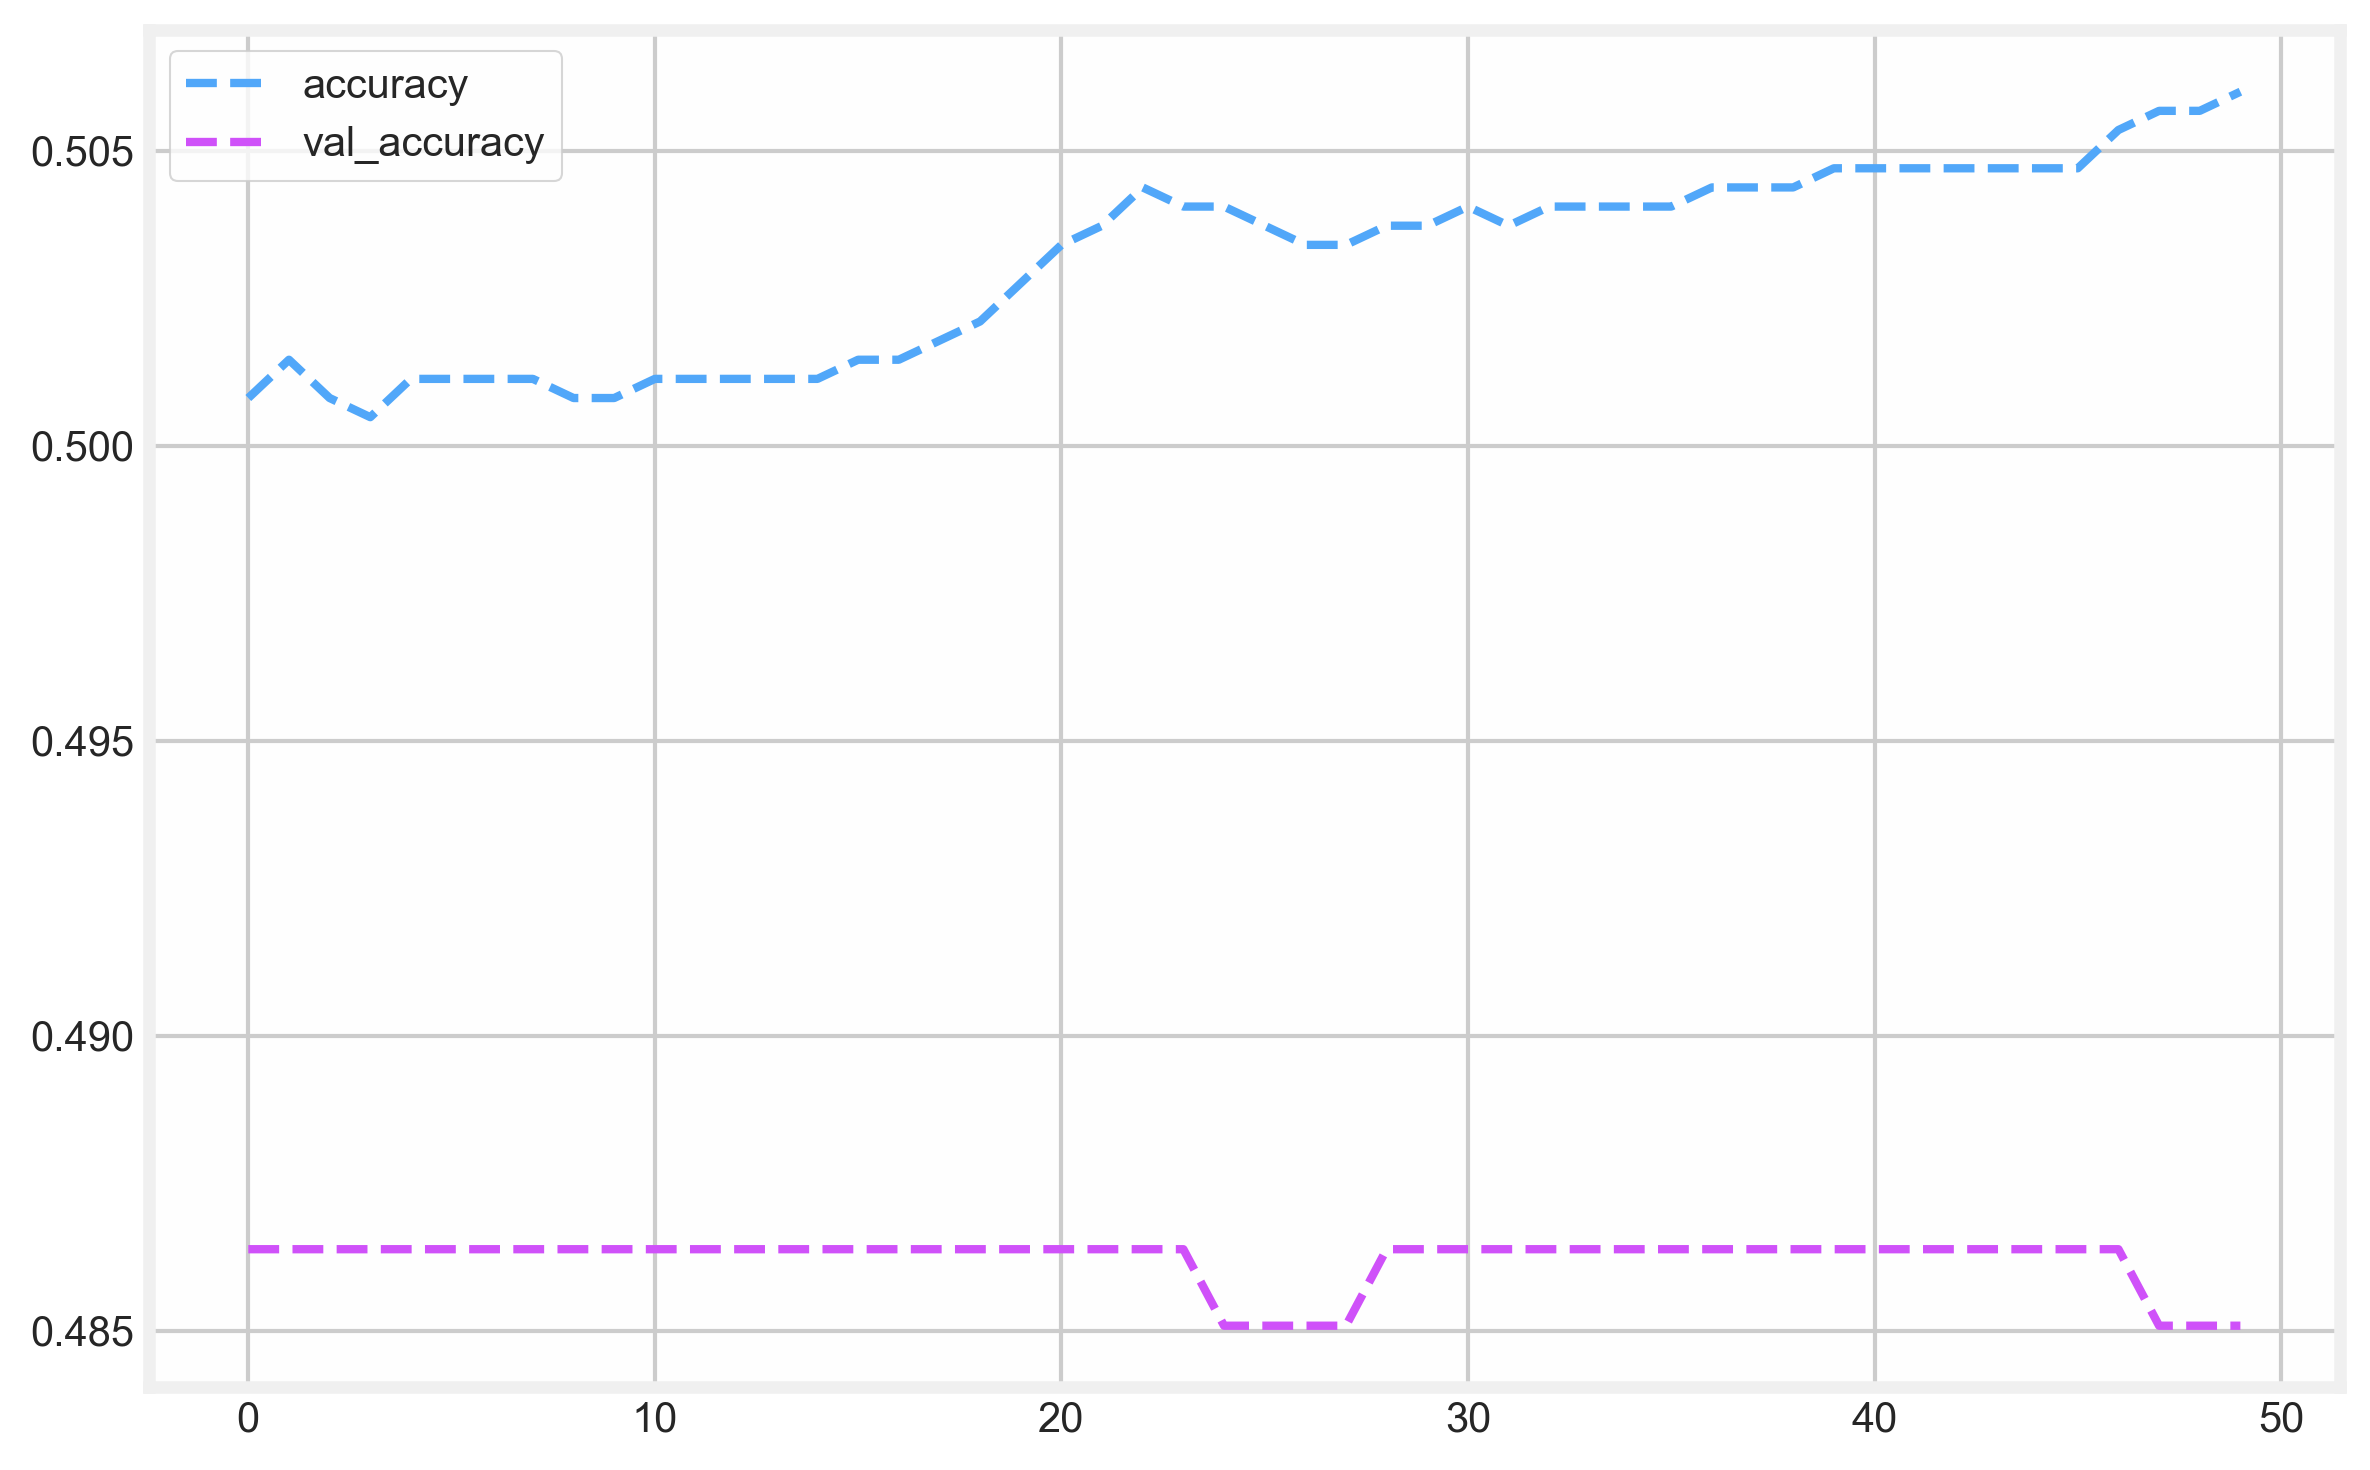

In [64]:
res[['accuracy', 'val_accuracy']].plot(style='--');

In [65]:
set_seeds()
model = create_model(hl=2, hu=128,
                     dropout=True, rate=0.3,
                     regularize=True, reg=l2(0.001),
                    )

In [66]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=get_class_weight(train))

CPU times: user 11.6 s, sys: 6.5 s, total: 18.1 s
Wall time: 7.19 s


In [67]:
model.evaluate(train_[cols], train['d'])

121/121 [==============================] - 0s 683us/step - loss: 0.7450 - accuracy: 0.4912


[0.7450017929077148, 0.4911734163761139]

In [68]:
model.evaluate(test_[cols], test['d'])

31/31 [==============================] - 0s 658us/step - loss: 0.7438 - accuracy: 0.5052


[0.7438210248947144, 0.5051867365837097]

In [69]:
res = pd.DataFrame(hist.history)

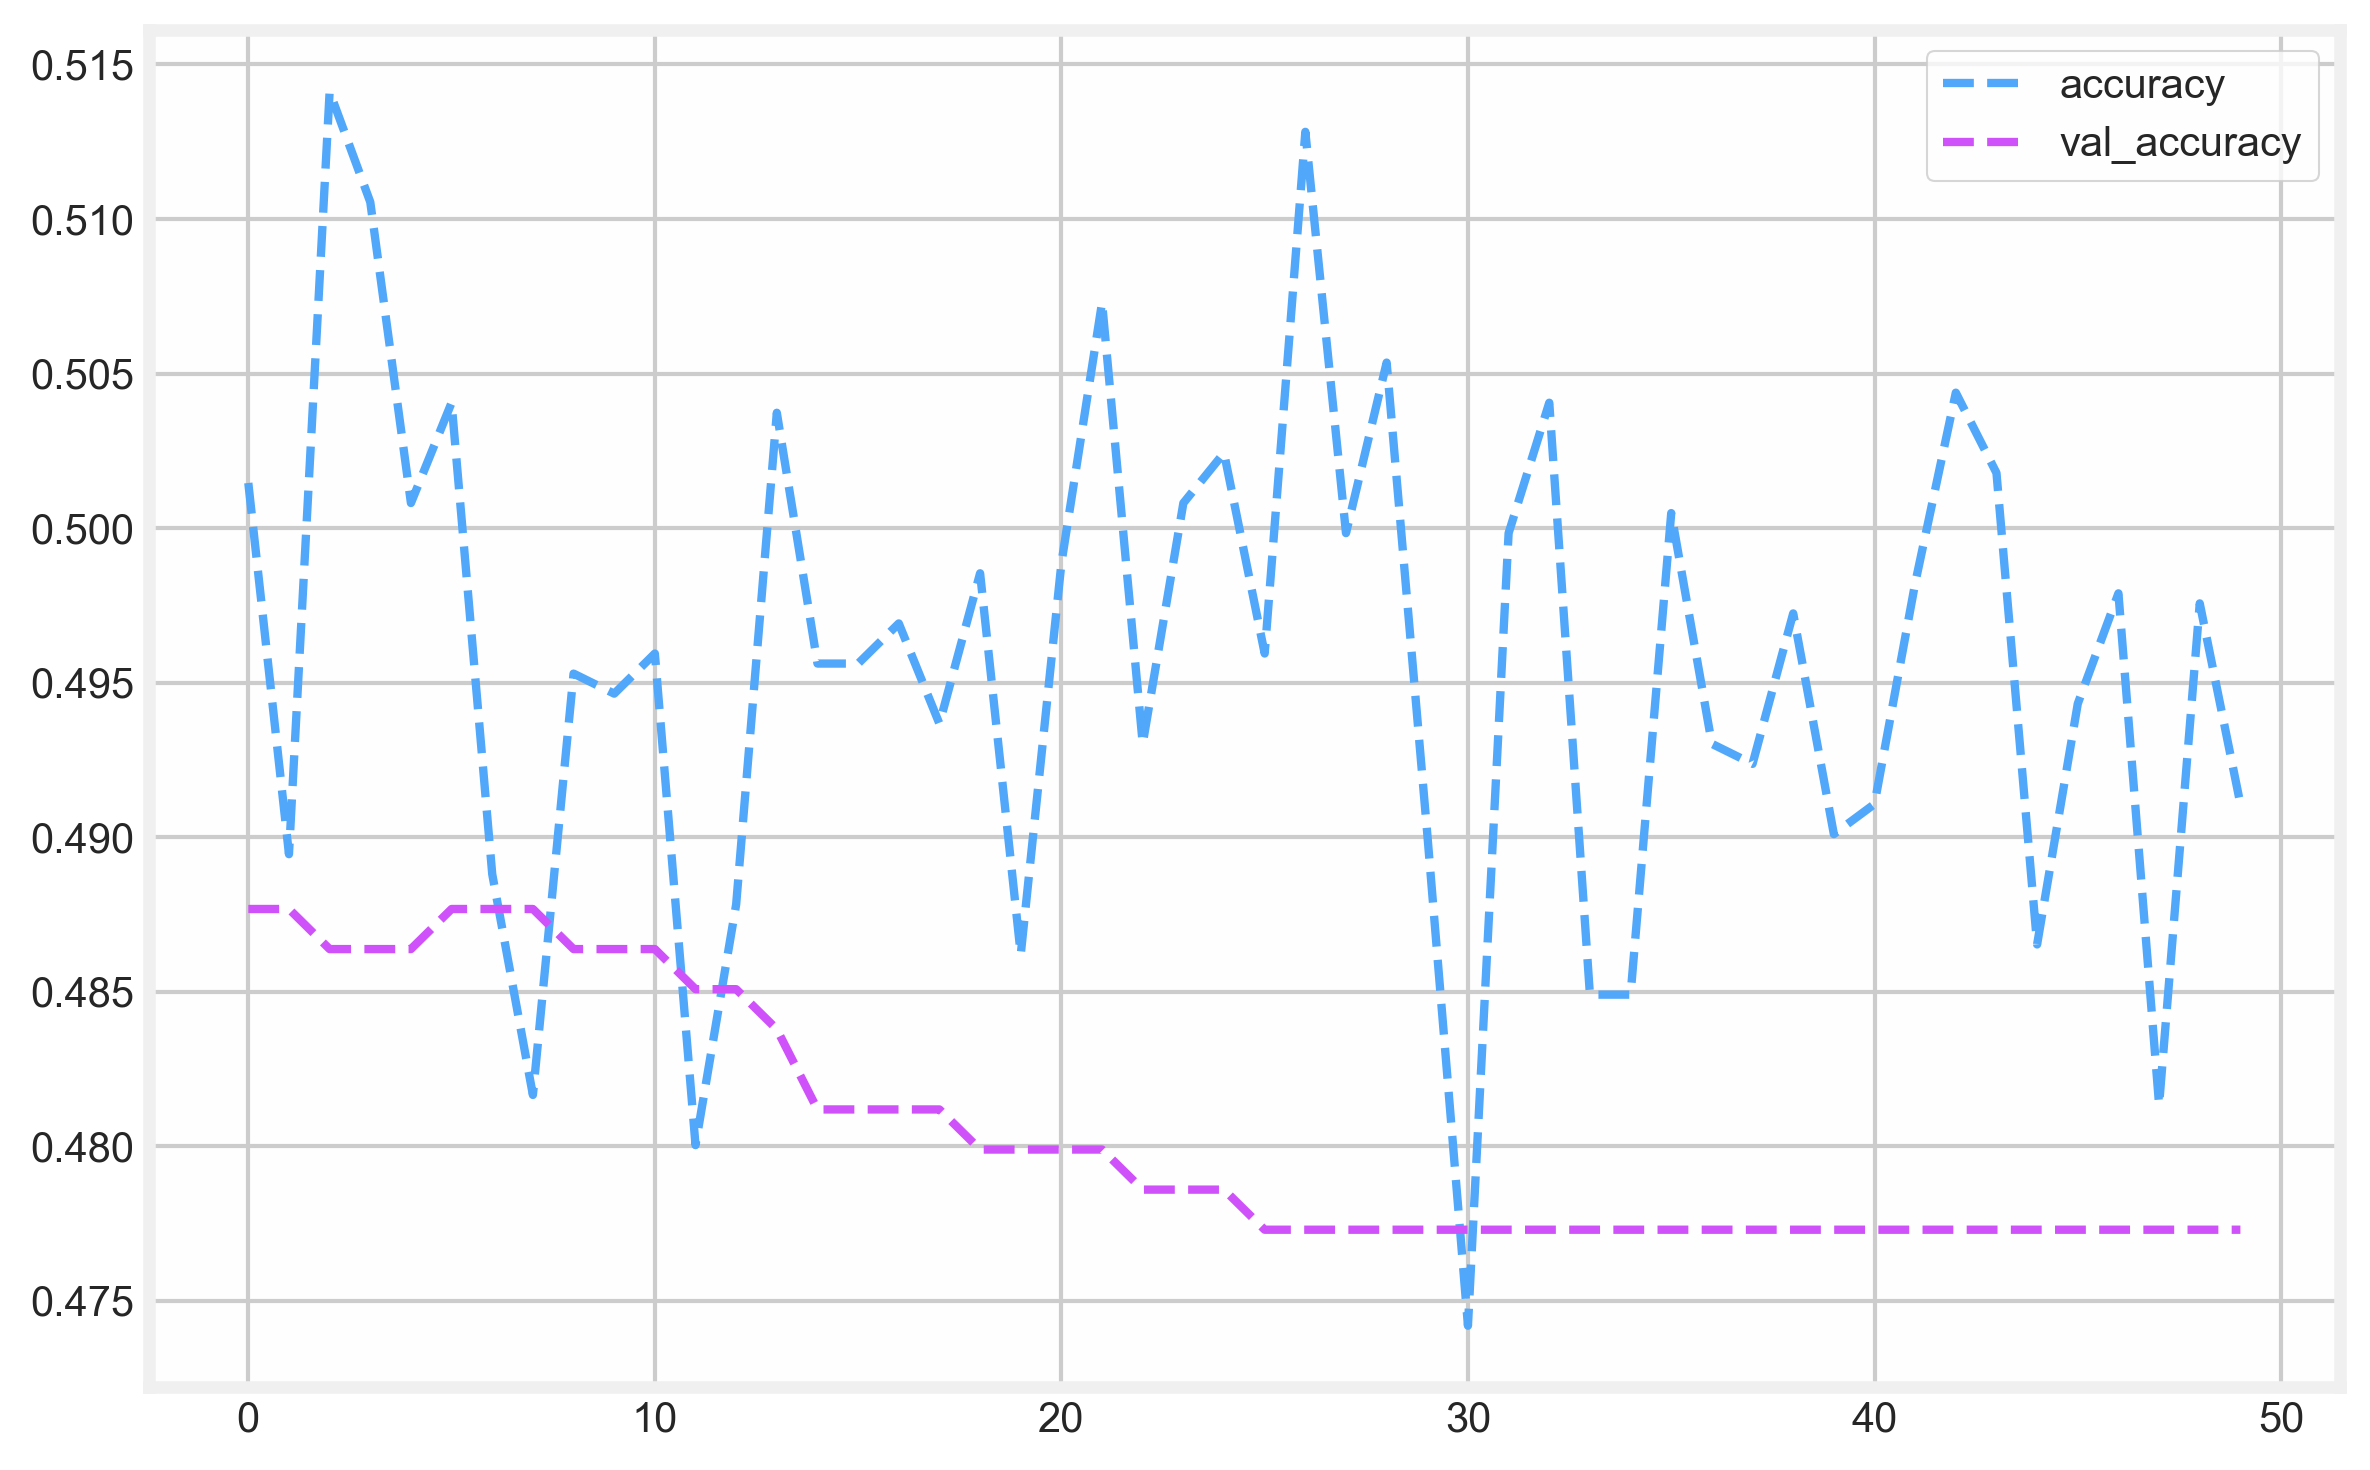

In [70]:
res[['accuracy', 'val_accuracy']].plot(style='--');

In [71]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

0.015268230438232444

## Bagging

Strategies known as ensemble learning combine the predictions from many models. To get a forecast that is both more stable and frequently better than any individual member model's prediction, it is essential for the models that comprise the ensemble to be good in a variety of ways.
Training each model on a distinct subset of the available training data is one technique to produce differences between the models. Through the use of resampling techniques like cross-validation and the bootstrap, which are intended to estimate the average performance of the model often on unseen data, models are naturally trained on various subsets of the training data. 

In [72]:
len(cols)

40

In [73]:
max_features = 0.75

In [74]:
set_seeds()
base_estimator = KerasClassifier(model=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=True, regularize=False,
                        input_dim=int(len(cols) * max_features))

In [75]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [76]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: user 37.1 s, sys: 17.6 s, total: 54.6 s
Wall time: 26.9 s


BaggingClassifier(base_estimator=KerasClassifier(dropout=True, epochs=20, hl=1, hu=128, input_dim=30, model=<function create_model at 0x1665039d0>, regularize=False, verbose=False),
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [77]:
model_bag.score(train_[cols], train['d'])

0.48598130841121495

In [78]:
model_bag.score(test_[cols], test['d'])

0.4854771784232365

In [79]:
test['p'] = model_bag.predict(test_[cols])

In [80]:
test['p'].value_counts()

1    823
0    141
Name: p, dtype: int64

## Optimizers

In [81]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam','ftrl']

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

In [82]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer, activation=activation
                    )
    start = time.time()
    model.fit(train_[cols], train['d'],
              epochs=2000, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=get_class_weight(train), callbacks=[callback])
    stop = time.time()
    time_ = stop - start
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {time_:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 1.9315 | in-sample=0.5382 | out-of-sample=0.4969
rmsprop    | time[s]: 3.8131 | in-sample=0.6096 | out-of-sample=0.4876
adagrad    | time[s]: 1.9603 | in-sample=0.5135 | out-of-sample=0.4979
adadelta   | time[s]: 1.3882 | in-sample=0.4982 | out-of-sample=0.4938
adam       | time[s]: 3.0090 | in-sample=0.5963 | out-of-sample=0.4927
adamax     | time[s]: 2.0663 | in-sample=0.5649 | out-of-sample=0.4948
nadam      | time[s]: 4.4880 | in-sample=0.6098 | out-of-sample=0.4855
ftrl       | time[s]: 1.4559 | in-sample=0.4984 | out-of-sample=0.4927
CPU times: user 29.3 s, sys: 5.57 s, total: 34.9 s
Wall time: 21.5 s


In [84]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [85]:
test['p'].value_counts()

1    964
Name: p, dtype: int64

In [86]:
accuracy_score(test['p'], test['d'])

0.4927385892116183

## Activation

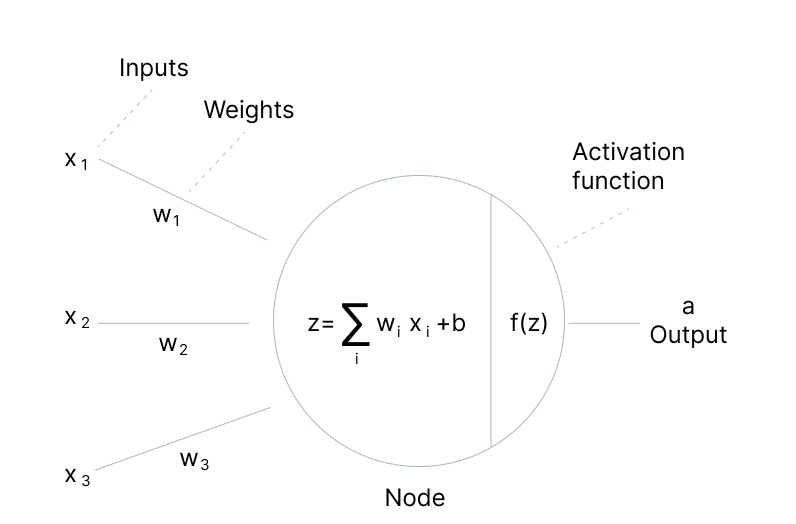

### Activation function

Activation functions are used at the end of a hidden unit to introduce non-linear complexities to the model. So, we use activation functions to make the incoming data nonlinear. Hence, an activation function is a decision making function. Here are the most common ones:

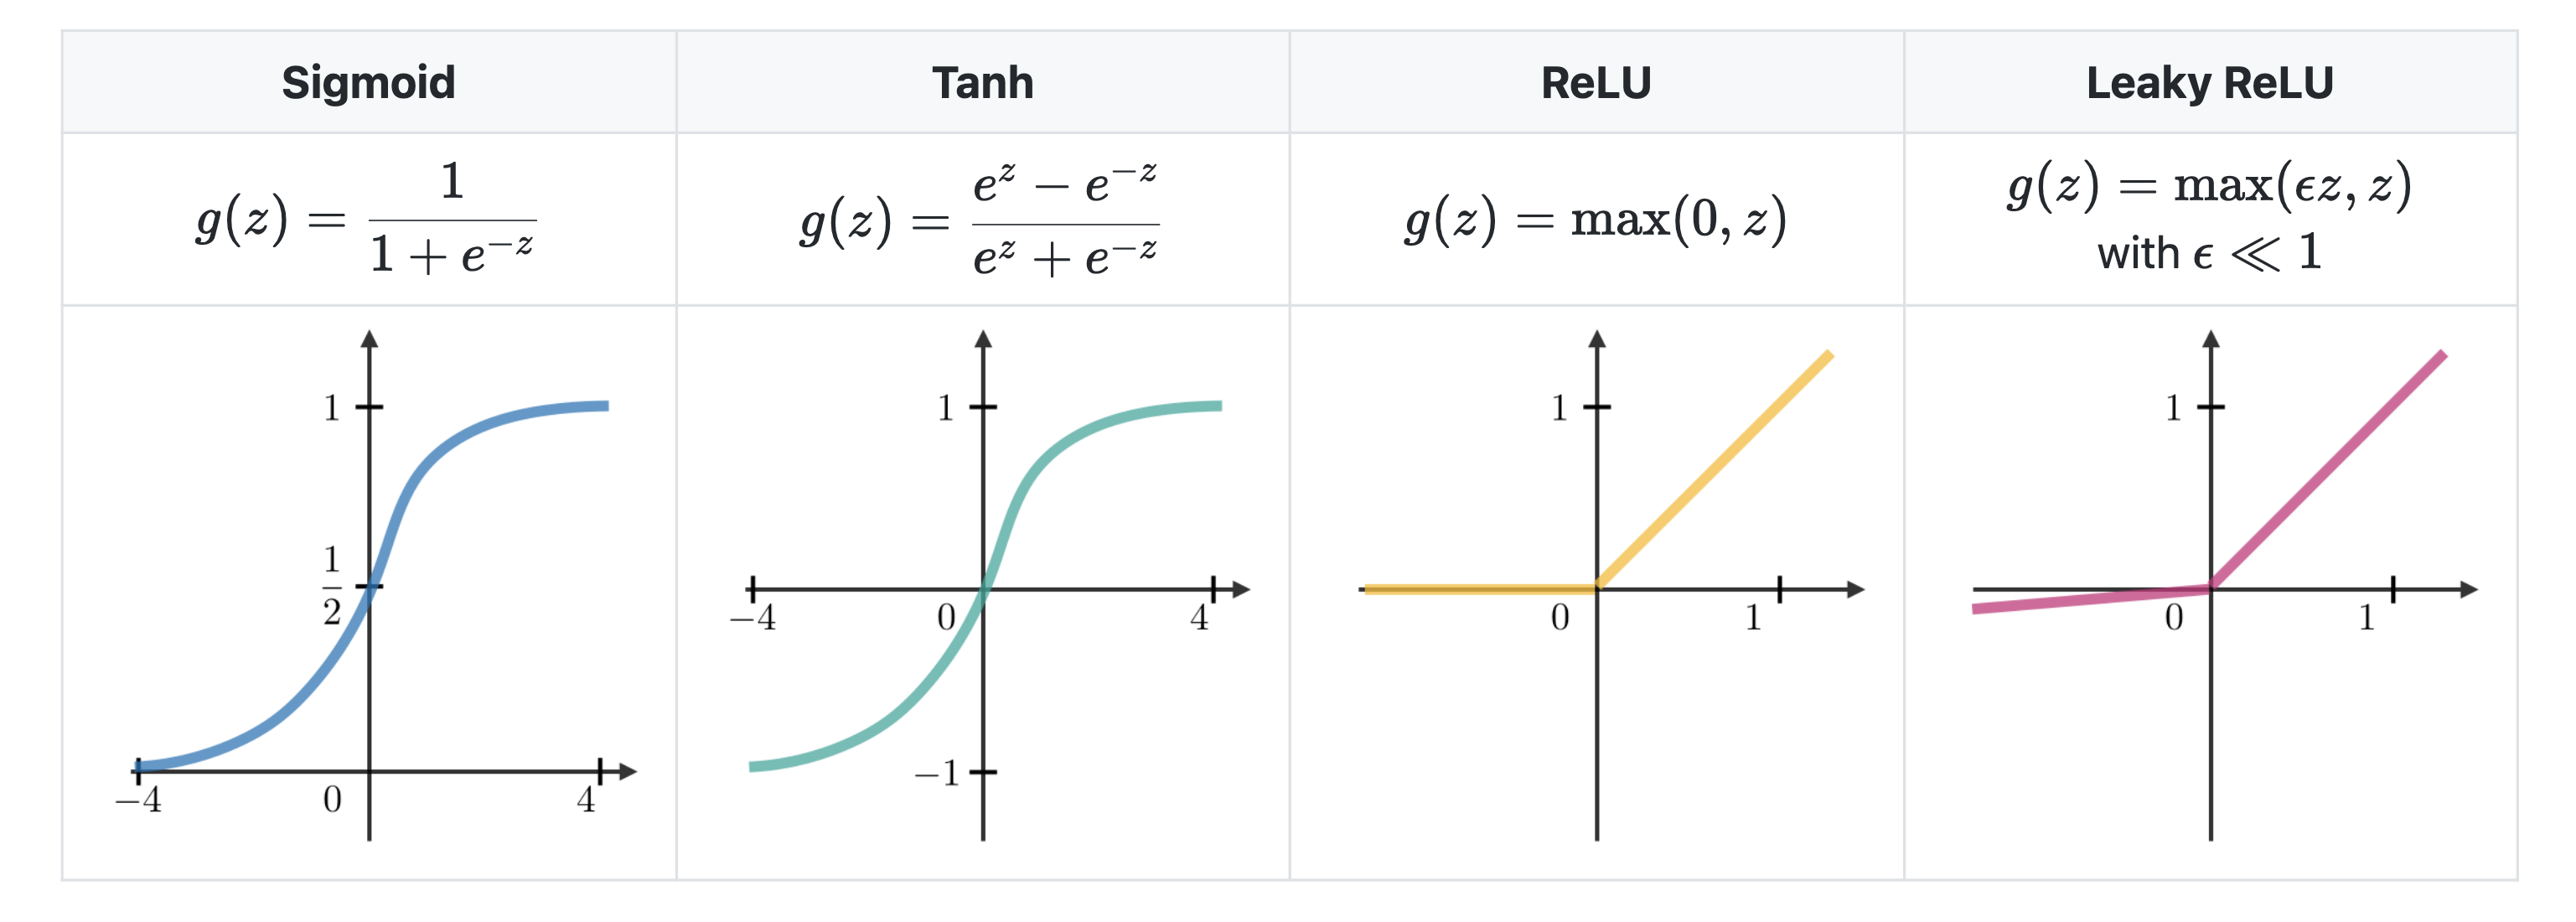

In [87]:
activations = ['relu', 'sigmoid', 'softmax', 'softplus',
              'softsign', 'tanh', 'selu','elu']

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

In [88]:
%%time
for activation in activations:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer, activation=activation
                    )
    start = time.time()
    model.fit(train_[cols], train['d'],
              epochs=2000, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=get_class_weight(train), callbacks=[callback])
    stop = time.time()
    time_ = stop - start
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{activation:10s} | time[s]: {time_:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

relu       | time[s]: 1.2131 | in-sample=0.4984 | out-of-sample=0.4927
sigmoid    | time[s]: 1.2130 | in-sample=0.4984 | out-of-sample=0.4927
softmax    | time[s]: 1.2356 | in-sample=0.4984 | out-of-sample=0.4927
softplus   | time[s]: 1.2612 | in-sample=0.5016 | out-of-sample=0.5073
softsign   | time[s]: 1.1804 | in-sample=0.4984 | out-of-sample=0.4927
tanh       | time[s]: 1.1830 | in-sample=0.4984 | out-of-sample=0.4927
selu       | time[s]: 1.2113 | in-sample=0.4984 | out-of-sample=0.4927
elu        | time[s]: 1.1978 | in-sample=0.4984 | out-of-sample=0.4927
CPU times: user 14.5 s, sys: 3.14 s, total: 17.7 s
Wall time: 11.3 s
